In [37]:
# Импорт необходимых модулей, библиотек, классов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [78]:
# загрузим данные
data_orig = pd.read_csv('data/ab_data_tourist.csv')

In [79]:
# Сделаем копию для быстрого восстановления без повторной загрузки
data = data_orig.copy()

In [40]:
# Общая информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


### Видно, что количество непустых ячеек равно общему количеству столбцов, значит пропусков в данных нет

In [80]:
# преобразуем тип столбца date к типу datetime
data['date'] = pd.to_datetime(data['date'])

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


In [44]:
data.describe()

,user_id,date,purchase,price
count,294478.000000,294478,294478.000000,294478.000000
mean,787974.124733,2021-01-13 01:39:48.011328,0.119659,10154.782361
min,630000.000000,2021-01-02 00:00:00,0.000000,0.000000
25%,709032.250000,2021-01-08 00:00:00,0.000000,0.000000
50%,787933.500000,2021-01-13 00:00:00,0.000000,0.000000
75%,866911.750000,2021-01-19 00:00:00,0.000000,0.000000
max,945999.000000,2021-01-24 00:00:00,1.000000,200000.000000
std,91210.823776,NaN,0.324563,35153.824872


In [81]:
# Убедимся, что в поле purchase у нас только 0 или 1
print(data['purchase'].sum() / data['purchase'][data['purchase'] != 0].count())

1.0


In [82]:
# Проверим длительность теста в группах

date_a_min = data[data['group'] == 'A']['date'].min()
date_a_max = data[data['group'] == 'A']['date'].max()

date_b_min = data[data['group'] == 'B']['date'].min()
date_b_max = data[data['group'] == 'B']['date'].max()

print(f'Самая ранняя дата в группе А {date_a_min}\nСамая ранняя дата в группе B {date_b_min}')
print(f'Самая поздняя дата в группе A {date_a_max}\nСамая поздняя дата в группе B {date_b_max}')

Самая ранняя дата в группе А 2021-01-02 00:00:00
Самая ранняя дата в группе B 2021-01-02 00:00:00
Самая поздняя дата в группе A 2021-01-24 00:00:00
Самая поздняя дата в группе B 2021-01-24 00:00:00


### Длительность проведения тестирования в группах одинаковая

In [83]:
# Группировка по user_id и подсчет уникальных значений в столбце 'group'
group_counts = data.groupby('user_id')['group'].nunique()

# Фильтрация пользователей, попавших в разные группы
users_in_multiple_groups = group_counts[group_counts > 1].index

# Удаление строк из DataFrame для пользователей, попавших в разные группы
data = data[~data['user_id'].isin(users_in_multiple_groups)]

print(f'Удалено {users_in_multiple_groups.shape[0]}')

Удалено 1895


In [46]:
# # Проверим наличие одних и тех же пользователей в разных группах

# # Находим строки с одинаковыми значениями в столбце 'user_id'
# duplicated_rows = data[data.duplicated('user_id', keep=False)]

# print(f'Количество одинаковых пользователей в обеих группах {duplicated_rows.shape[0]}')

# # Удаление найденных строк
# if (duplicated_rows.shape[0] > 0):
#     # comment: при наличии удаляем
#     data = data.drop(duplicated_rows.index)
#     print(f'Удалено {duplicated_rows.shape[0]} записей.')
# else:
#     # comment: одинаковых пользователей не найдено
#     print('Одинаковых пользователей не найдено.')
# # end if



Удалено 7788 записей.


In [85]:
# Проверим сбалансированность выборки

count_a = data[data['group'] == 'A'].shape[0]
count_b = data[data['group'] == 'B'].shape[0]

print(f'Количество пользователей в группе А {count_a}\nКоличество пользователей в группе B {count_b}')
disbalance_percent = abs(count_a - count_b) / max(count_a, count_b)
print(f'Дисбаланс в группах {disbalance_percent:.2%}')

Количество пользователей в группе А 145307
Количество пользователей в группе B 145381
Дисбаланс в группах 0.05%


### Выборка достаточно сбалансирована

In [ ]:
# # Сравняем количество записей по классам, удалив часть строк

# count_a = data['group'][data['group'] == 'A'].count()
# count_b = data['group'][data['group'] == 'B'].count()

# if (count_a < count_b):
#     # comment: Если в группе В больше, чем в группе А
#     num_rows_to_delete = count_b - count_a
#     rows_to_delete = data[data['group'] == 'B'].sample(n=num_rows_to_delete).index

#     # Удаление выбранных строк
#     data = data.drop(rows_to_delete)
#     print(f'Удалено {num_rows_to_delete} записей из группы В')
# elif (count_a > count_b):
#     # comment: Если в группе А больше, чем в группе В
#     num_rows_to_delete = count_a - count_b
#     rows_to_delete = data[data['group'] == 'A'].sample(n=num_rows_to_delete).index

#     # Удаление выбранных строк
#     data = data.drop(rows_to_delete)
#     print(f'Удалено {num_rows_to_delete} записей из группы А')
# elif (count_a == count_b):
#     # comment: Если количество пользователей в группах одинаково
#     print('Количество пользователей в группах одинаково')
# # end if


# # Проверим количественное равенство классов А и В
# count_a = data['group'][data['group'] == 'A'].count()
# count_b = data['group'][data['group'] == 'B'].count()
# count_all = data.shape[0]

# print(f'Количество в классе А {count_a} \nКоличество в классе В {count_b}\nСумма А+В {count_a + count_b}\nВсего записей {count_all}')

In [89]:
# Рассчитаем вспомогательные показатели для контрольной и тестовой групп

# Сгруппируем по группе и рассчитаем показатели
grouped_df = data.groupby('group').agg({'user_id': ['count'], 'purchase': ['sum'], 'price': ['sum']})

# Переименуем столбцы для удобства
grouped_df.columns = ['_'.join(col) for col in grouped_df.columns]

print(grouped_df)

       user_id_count  purchase_sum   price_sum
group                                         
A             145307         17487  1417780000
B             145381         17290  1533010000


### Количество посещений обоих вариантов посадочной страницы соспоставимо, выборки сбаласнированы

In [88]:
# В каждой из групп рассчитайте ключевые показатели - конверсию и средний чек

grouped_df['conversion'] = grouped_df['purchase_sum'] / grouped_df['user_id_count']
grouped_df['mean_purchase'] = grouped_df['price_sum'] / grouped_df['user_id_count']

print(grouped_df)

       user_id_count  purchase_sum   price_sum  conversion  mean_purchase
group                                                                    
A             145307         17487  1417780000    0.120345    9757.134894
B             145381         17290  1533010000    0.118929   10544.775452


### На первый взгляд, вариант А эффективнее варианта В по конверсии, а варинат В эффективнее варианта А по сумме среднего чека.

In [92]:
# Построение сводной таблицы
pivot_table = pd.pivot_table(data, values='purchase', index='group', columns='price', aggfunc='sum', fill_value=0)

# Вывод сводной таблицы
pivot_table


price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


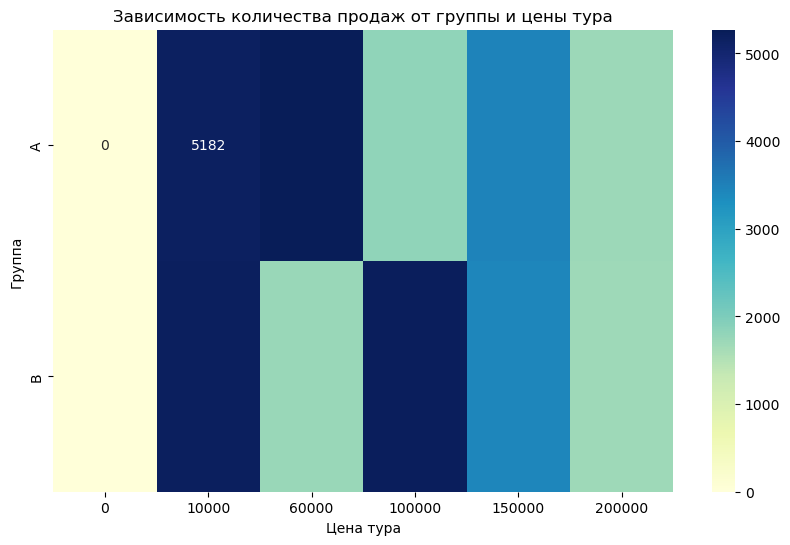

In [97]:
# Построение тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Зависимость количества продаж от группы и цены тура')
plt.xlabel('Цена тура')
plt.ylabel('Группа')
plt.show()


### Покупательская способность в группе А в отличие от группы В выше по турам стоимостью 60000, а в группе В покупательская способность выше по турам стоимостью 100000. По дешевым турам и турам стоимостью 150000-200000 покупательская способность в обеих группах одинаковая.

In [108]:
# Сгруппируем данные по дате и группе тестирования и построим таблицу с ежедневными данными результатов проведения A/B-тестирования

grouped_data = data.groupby(['date', 'group']).agg({'user_id': ['count'], 'purchase': ['sum'], 'price': ['sum']}).reset_index()
grouped_data.columns = ['date', 'group', 'users_count', 'purchase_count', 'purchase_sum']

display(grouped_data.head(6))


,date,group,users_count,purchase_count,purchase_sum
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000
5,2021-01-04,B,6536,764,68030000


In [110]:
# Добавим в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном 
# среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

grouped_data['daily_conv'] = grouped_data['purchase_count'] / grouped_data['users_count']
grouped_data['daily_mean_check'] = grouped_data['purchase_sum'] / grouped_data['purchase_count']

display(grouped_data.head(6))

,date,group,users_count,purchase_count,purchase_sum,daily_conv,daily_mean_check
0,2021-01-02,A,2854,359,29410000,0.125788,81922.005571
1,2021-01-02,B,2861,345,29660000,0.120587,85971.014493
2,2021-01-03,A,6596,748,62000000,0.113402,82887.700535
3,2021-01-03,B,6619,754,65960000,0.113914,87480.106101
4,2021-01-04,A,6566,799,64250000,0.121687,80413.016270
5,2021-01-04,B,6536,764,68030000,0.116891,89044.502618


In [123]:
# Рассчитаем кумулятивные показатели
grouped_data_a = grouped_data[grouped_data['group'] == 'A'].copy()

grouped_data_a['cum_users'] = grouped_data_a['users_count'].cumsum()
grouped_data_a['cum_transactions'] = grouped_data_a['purchase_count'].cumsum()
grouped_data_a['cum_revenue'] = grouped_data_a['purchase_sum'].cumsum()
grouped_data_a['cum_conv'] = grouped_data_a['cum_transactions'] / grouped_data_a['cum_users']
grouped_data_a['cum_mean_check'] = grouped_data_a['cum_revenue'] / grouped_data_a['cum_transactions']

display(grouped_data_a.head(6))

grouped_data_b = grouped_data[grouped_data['group'] == 'B'].copy()

grouped_data_b['cum_users'] = grouped_data_b['users_count'].cumsum()
grouped_data_b['cum_transactions'] = grouped_data_b['purchase_count'].cumsum()
grouped_data_b['cum_revenue'] = grouped_data_b['purchase_sum'].cumsum()
grouped_data_b['cum_conv'] = grouped_data_b['cum_transactions'] / grouped_data_b['cum_users']
grouped_data_b['cum_mean_check'] = grouped_data_b['cum_revenue'] / grouped_data_b['cum_transactions']

display(grouped_data_b.head(6))

,date,group,users_count,purchase_count,purchase_sum,daily_conv,daily_mean_check,cum_users,cum_transactions,cum_revenue,cum_conv,cum_mean_check
0,2021-01-02,A,2854,359,29410000,0.125788,81922.005571,2854,359,29410000,0.125788,81922.005571
2,2021-01-03,A,6596,748,62000000,0.113402,82887.700535,9450,1107,91410000,0.117143,82574.525745
4,2021-01-04,A,6566,799,64250000,0.121687,80413.016270,16016,1906,155660000,0.119006,81668.415530
6,2021-01-05,A,6433,790,64550000,0.122804,81708.860759,22449,2696,220210000,0.120094,81680.267062
8,2021-01-06,A,6606,764,63410000,0.115652,82997.382199,29055,3460,283620000,0.119084,81971.098266
10,2021-01-07,A,6579,795,67290000,0.120839,84641.509434,35634,4255,350910000,0.119408,82470.035253


,date,group,users_count,purchase_count,purchase_sum,daily_conv,daily_mean_check,cum_users,cum_transactions,cum_revenue,cum_conv,cum_mean_check
1,2021-01-02,B,2861,345,29660000,0.120587,85971.014493,2861,345,29660000,0.120587,85971.014493
3,2021-01-03,B,6619,754,65960000,0.113914,87480.106101,9480,1099,95620000,0.115928,87006.369427
5,2021-01-04,B,6536,764,68030000,0.116891,89044.502618,16016,1863,163650000,0.116321,87842.190016
7,2021-01-05,B,6511,749,63550000,0.115036,84846.461949,22527,2612,227200000,0.115950,86983.154671
9,2021-01-06,B,6751,838,75020000,0.124130,89522.673031,29278,3450,302220000,0.117836,87600.000000
11,2021-01-07,B,6616,767,67170000,0.115931,87574.967405,35894,4217,369390000,0.117485,87595.447000


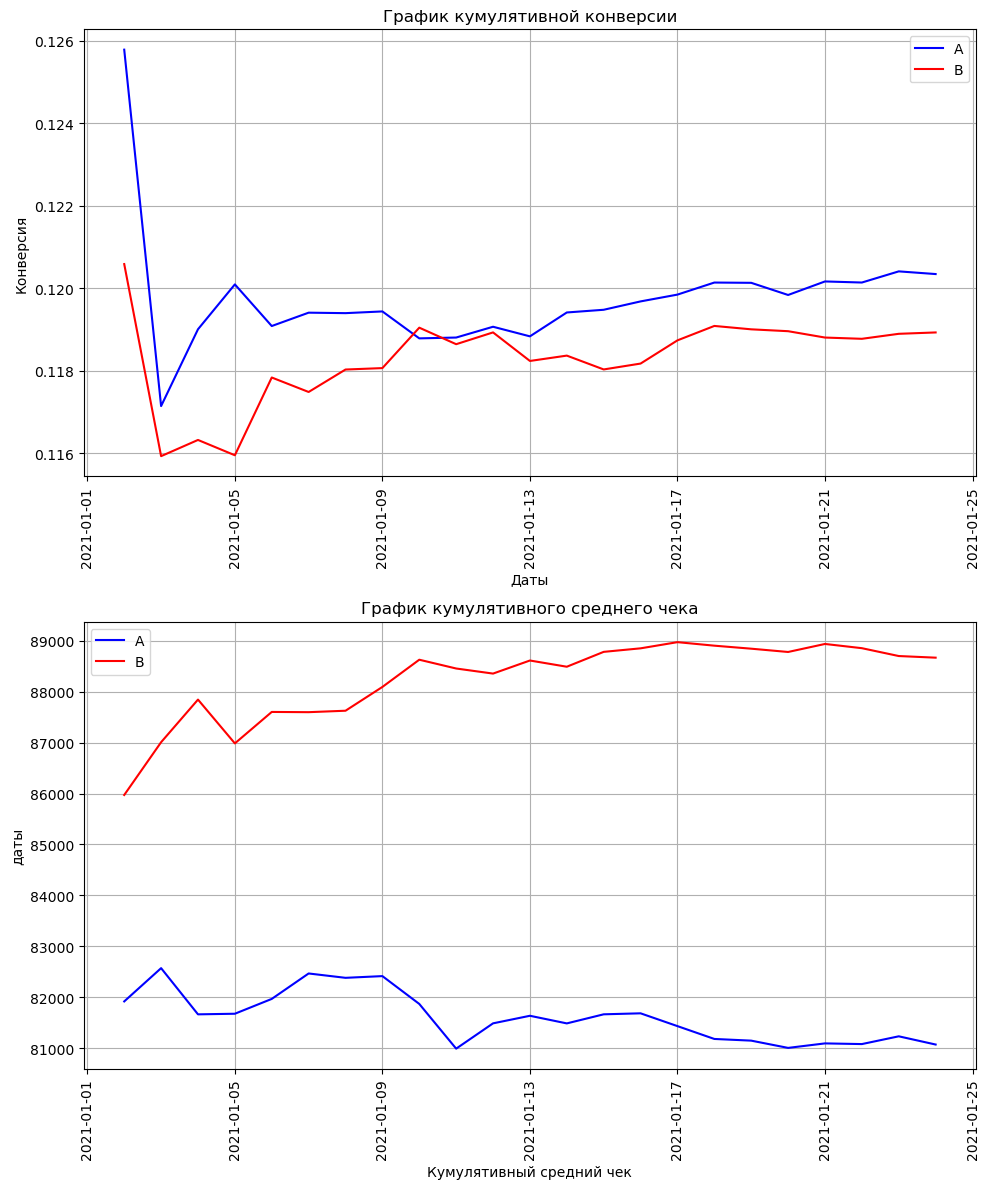

In [130]:
plt.figure(figsize=(10, 12))  

plt.subplot(2, 1, 1)
plt.plot(grouped_data_a['date'], grouped_data_a['cum_conv'], label='A', color='blue')
plt.plot(grouped_data_b['date'], grouped_data_b['cum_conv'], label='B', color='red')
plt.title('График кумулятивной конверсии')
plt.xlabel('Даты')
plt.ylabel('Конверсия')
plt.legend()  # Добавление легенды
plt.grid(True)  # Включение сетки
plt.xticks(rotation=90)

plt.subplot(2, 1, 2)
plt.plot(grouped_data_a['date'], grouped_data_a['cum_mean_check'], label='A', color='blue')
plt.plot(grouped_data_b['date'], grouped_data_b['cum_mean_check'], label='B', color='red')
plt.title('График кумулятивного среднего чека')
plt.xlabel('Кумулятивный средний чек')
plt.ylabel('Даты')
plt.legend()  # Добавление легенды
plt.grid(True)  # Включение сетки
plt.xticks(rotation=90)

# Показать график
plt.tight_layout()
plt.show()

### Тест можно считать завершенным, на графиках хорошо видно, что значения метрик стабилизировались во времени. Графики кумулятивных показателей не пересекаются. На графике конверсии заметно, что варианты повторяют профиль друг друга.

In [148]:
df_man = pd.concat([grouped_data_a, grouped_data_b], axis=0)
df_man.tail(10)

,date,group,users_count,purchase_count,purchase_sum,daily_conv,daily_mean_check,cum_users,cum_transactions,cum_revenue,cum_conv,cum_mean_check
27,2021-01-15,B,6563,747,69160000,0.113820,92583.668005,88917,10495,931730000,0.118031,88778.465936
29,2021-01-16,B,6544,786,70560000,0.120110,89770.992366,95461,11281,1002290000,0.118174,88847.619892
31,2021-01-17,B,6546,831,75300000,0.126948,90613.718412,102007,12112,1077590000,0.118737,88968.791281
33,2021-01-18,B,6603,822,72240000,0.124489,87883.211679,108610,12934,1149830000,0.119087,88899.798979
35,2021-01-19,B,6562,772,67820000,0.117647,87849.740933,115172,13706,1217650000,0.119005,88840.653728
37,2021-01-20,B,6685,790,69250000,0.118175,87658.227848,121857,14496,1286900000,0.118959,88776.214128
39,2021-01-21,B,6555,760,69870000,0.115942,91934.210526,128412,15256,1356770000,0.118805,88933.534347
41,2021-01-22,B,6659,787,68660000,0.118186,87242.693774,135071,16043,1425430000,0.118775,88850.589042
43,2021-01-23,B,6633,805,68930000,0.121363,85627.329193,141704,16848,1494360000,0.118896,88696.581197
45,2021-01-24,B,3677,442,38650000,0.120207,87443.438914,145381,17290,1533010000,0.118929,88664.545980


### Подготовим данные для проведения статистических тестов

In [144]:
converted_piv= df_man.groupby('group')[['purchase_count', 'users_count']].sum().reset_index()
display(converted_piv)

,group,purchase_count,users_count
0,A,17487,145307
1,B,17290,145381


In [145]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['purchase_count'],
    nobs=converted_piv['users_count'],
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


### Статистической разницы между конверсиями нет

In [160]:
import numpy as np
from scipy.stats import ttest_ind

# Данные по средним чекам
checks_A = grouped_data_a['daily_mean_check']  
checks_B = grouped_data_b['daily_mean_check']

# t-тест для двух независимых выборок
t_stat, p_value = ttest_ind(checks_A, checks_B, equal_var=False)
print(f'T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}')

if p_value < 0.05:
    print("Есть статистическая разница между средними чеками в группах A и B.")
else:
    print("Нет статистической разницы между средними чеками в группах A и B.")

T-statistic: -9.6091, P-value: 0.0000
Есть статистическая разница между средними чеками в группах A и B.


### Построим доверительный 95% интервалы для конверсий в каждой из групп, разницы конверсий в группах, ежедневного среднего чека в каждой из групп.

In [162]:
import numpy as np
from scipy import stats

group_a = df_man[df_man['group'] == 'A']
group_b = df_man[df_man['group'] == 'B']

n1 = group_a['users_count'].sum()
x1 = group_a['purchase_count'].sum()
mean1 = group_a['daily_mean_check'].mean()
std1 = group_a['daily_mean_check'].std()

n2 = group_b['users_count'].sum()
x2 = group_b['purchase_count'].sum()
mean2 = group_b['daily_mean_check'].mean()
std2 = group_b['daily_mean_check'].std()


# Конверсии
p1 = x1 / n1
p2 = x2 / n2

# 95% доверительный интервал для конверсий в первой группе
ci1_low, ci1_high = stats.norm.interval(0.95, loc=p1, scale=np.sqrt(p1 * (1 - p1) / n1))

# 95% доверительный интервал для конверсий во второй группе
ci2_low, ci2_high = stats.norm.interval(0.95, loc=p2, scale=np.sqrt(p2 * (1 - p2) / n2))

# Разница конверсий
diff = p1 - p2
se_diff = np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
ci_diff_low, ci_diff_high = stats.norm.interval(0.95, loc=diff, scale=se_diff)

# 95% доверительный интервал для среднего чека в первой группе
ci_mean1_low, ci_mean1_high = stats.t.interval(0.95, df=n1-1, loc=mean1, scale=std1 / np.sqrt(n1))

# 95% доверительный интервал для среднего чека во второй группе
ci_mean2_low, ci_mean2_high = stats.t.interval(0.95, df=n2-1, loc=mean2, scale=std2 / np.sqrt(n2))

# Вывод результатов
print(f'95% доверительный интервал для конверсий в первой группе: [{ci1_low:.3f}, {ci1_high:.3f}]')
print(f'95% доверительный интервал для конверсий во второй группе: [{ci2_low:.3f}, {ci2_high:.3f}]')
print(f'95% доверительный интервал для разницы конверсий: [{ci_diff_low:.3f}, {ci_diff_high:.3f}]')
print(f'95% доверительный интервал для среднего чека в первой группе: [{ci_mean1_low:.3f}, {ci_mean1_high:.3f}]')
print(f'95% доверительный интервал для среднего чека во второй группе: [{ci_mean2_low:.3f}, {ci_mean2_high:.3f}]')


95% доверительный интервал для конверсий в первой группе: [0.119, 0.122]
95% доверительный интервал для конверсий во второй группе: [0.117, 0.121]
95% доверительный интервал для разницы конверсий: [-0.001, 0.004]
95% доверительный интервал для среднего чека в первой группе: [80953.365, 80985.205]
95% доверительный интервал для среднего чека во второй группе: [88564.424, 88587.007]


### Доверительные интервалы для конверсий обозначают диапазон, в котором мы ожидаем, что находится истинная конверсия в каждой группе с вероятностью 95%. Перекрытие доверительных интервалов для конверсий в двух группах (от 0.117 до 0.122) говорит о том, что статистически значимых различий в конверсиях между группами нет. Разница в конверсиях в среднем составляет от -0.001 до 0.004, что также указывает на отсутствие значимых различий.



### Доверительные интервалы для среднего чека в каждой из групп не перекрываются: в первой группе средний чек ожидается быть между 80,953.365 и 80,985.205, в то время как во второй группе средний чек ожидается быть между 88,564.424 и 88,587.007. Это указывает на статистически значимые различия в среднем чеке между двумя группами. В контексте бизнеса это может означать, что изменение, которое было внесено в группу B, привело к изменению среднего чека в этой группе.

### Таким образом, в этом случае наблюдаются статистически значимые различия в среднем чеке между группами, в то время как по конверсиям таких различий не наблюдается.

### Для проверки эффективности двух вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку — воспользуемся многофакторным дисперсионным анализом (MANOVA).

In [138]:
from statsmodels.multivariate.manova import MANOVA

maov = MANOVA.from_formula('cum_conv + cum_mean_check ~ group', data=df_man)
print(maov.mv_test())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept          Value    Num DF  Den DF   F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda     0.0001 2.0000 43.0000 250976.0502 0.0000
         Pillai's trace     0.9999 2.0000 43.0000 250976.0502 0.0000
 Hotelling-Lawley trace 11673.3047 2.0000 43.0000 250976.0502 0.0000
    Roy's greatest root 11673.3047 2.0000 43.0000 250976.0502 0.0000
--------------------------------------------------------------------
                                                                    
---------------------------------------------------------------------
           group            Value   Num DF   Den DF  F Value   Pr > F
---------------------------------------------------------------------
            Wilks' lambda   0.0350  2.0000  43.0000  

### Все тесты показывают очень значимые результаты (Pr > F = 0.0000), что указывает на наличие значимого общего эффекта модели.
### Wilks' lambda: Значение 0.0350, что близко к 0, указывает на значимые различия между группами.
### Pillai's trace: Значение 0.9650, что близко к 1, также указывает на значимые различия между группами.
### Hotelling-Lawley trace и Roy's greatest root также показывают высокие значения, что подтверждает значимые различия.
### Все тесты имеют Pr > F = 0.0000, что говорит о статистически значимых различиях между двумя вариантами посадочной страницы по двум критериям (конверсия и средний чек).

## Вывод
### Результаты MANOVA указывают на то, что существует статистически значимое влияние типа посадочной страницы (page_variant) на оба критерия — конверсию и средний чек. Это означает, что различия между вариантами A и B значимы и не являются случайными.

# Вывод: Вариант дизайна В более эффективен, т.к. дает увеличение среднего чека, несмотря на то, что конверсия остается без изменений.